### University of Niagara Falls Canada
### Master of Data Analytics
### DAMO-630-19 Advanced Data Analytics
### Final Project - Amazon Product Reviews - Sentiment Analysis
#### **By (Group3):**

*   **Catherine Calantoc**
*   **Sridevi Pemmasani**
*   **Jayasri Katragadda**
*   **Mounika Ravella**

# **Project Overview**

The Amazon Product Reviews Sentiment Analysis project uses advanced analytics and NLP to classify Amazon customer reviews as positive, negative, or neutral and extract actionable business insights. It includes building a dataset of product reviews, performing sentiment classification, and integrating a recommendation system driven by sentiment trends and customer preferences. Implemented on a cloud platform (e.g., Google Cloud), the project showcases end-to-end capabilities—from data preprocessing to predictive modeling and visualization.

---

## **Objectives**
- Explore customer review patterns, including class distribution, sample reviews, and review length.

- Build a baseline sentiment classifier using TF-IDF features and a Random Forest model, then evaluate its performance.

- Optimize the baseline model using grid search to find the best hyperparameters.

- Implement pretrained transformer models (e.g., BERT / RoBERTa) for advanced sentiment analysis.

- Compare all models and interpret their potential business impact.

---

## **Business Value**
- Converts customer reviews into actionable insights.
- Helps understand customer preferences, satisfaction, and issues.
- Guides product improvements and innovation.
- Enables sentiment-based recommendations to boost engagement and sales.
- Saves time and costs through automated analysis.
- Provides a competitive edge with timely response to market trends.

## 1. Import Libraries

In [1]:
# CORE
import pandas as pd
import numpy as np
import random
import re
import sys
import os
import io


# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Install (Colab): pip install transformers datasets evaluate accelerate
from datasets import Dataset

import torch
from torch.utils.data import DataLoader

In [2]:
from google.colab import files
uploaded = files.upload()


Saving synthetic_stratified_rating_1Lakh.csv to synthetic_stratified_rating_1Lakh.csv


## 2. Load Dataset

In [3]:
# Access the first file that was uploded if list of files uploaded
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), on_bad_lines='skip', engine='python')

print("Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Data loaded successfully!
Shape: (106188, 12)
Columns: ['product_id', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'rating_bin']


,product_id,discounted_price,actual_price,discount_percentage,rating,rating_count,user_id,user_name,review_id,review_title,review_content,rating_bin
0,B09TY4MSH3,1289.0,2499.0,48.0,3.3,73.0,AHEJQ5MN7YJB4A3XTDSTTZID3WKQ,NAVDEEP GUPTA,R1YWFT51T2HFXX,Pathetic,Not as responsive as the previous one. Need to...,Medium
1,B095RTJH1M,999.0,2899.0,66.0,4.6,26603.0,AFDITJCB5D4EOPYZKGP5RGRJFVLA,Abdul Moiz,RE1RVB3YIBPKD,Easy to install but a bit slippery,I used my 13 pro without a screen guard for a ...,Very_High
2,B099FDW2ZF,1235.0,1499.0,18.0,4.1,203.0,AHP67WDPXUM5SNLJEWOQWUM2LWLA,Vijay Pratap,RJ1FQK256DKD5,Handle to carry & a bit high stand would have ...,Best room heater in budget,High
3,B07HK53XM4,279.0,599.0,53.0,3.5,1367.0,AEAUQLBFFDELPJFM3F6JAIX4VWKA,Nawang,R1DM63YLI499R0,Very delicate product,but it is too diffuct to peel the tape,Medium
4,B0BFBNXS94,669.0,1499.0,55.0,2.3,13.0,AELE2SOO7LBNHXU7UK5F7TGQHA6Q,Been,RM9RH8FX9U95D,Do not buy!! Defective product,Waste of money. Defective product,Low


## 3. Inspect feature required for Sentiment Analysis

In [4]:
# Show a few rows (inspect review_title & review_content)
print("\nSample rows:")
display(df[["review_title", "review_content", "rating"]].head())


Sample rows:


,review_title,review_content,rating
0,Pathetic,Not as responsive as the previous one. Need to...,3.3
1,Easy to install but a bit slippery,I used my 13 pro without a screen guard for a ...,4.6
2,Handle to carry & a bit high stand would have ...,Best room heater in budget,4.1
3,Very delicate product,but it is too diffuct to peel the tape,3.5
4,Do not buy!! Defective product,Waste of money. Defective product,2.3


##### Concantenate riview_title and review_content as text column
- Both riview_title and review_content contribute to the customer review
- So, concatenate these 2 columns as text column
- rating column would be the label for analysis

In [5]:
#--------------- 2. Detect text & label columns ---------------
# For your file the likely text columns: 'review_title', 'review_content'
# Label column: 'rating' (may be float averages)
TEXT_COL = "review_content"   # choose 'review_title' for title-only, or concat both below
TITLE_COL = "review_title"
LABEL_COL = "rating"

# You may want to combine title + content:
df["text"] = df[[TITLE_COL, TEXT_COL]].fillna("").agg(" ".join, axis=1).str.strip()


#### Handle Label Column

In [6]:
# --------------- 3. Handle labels (convert to binary) ---------------
# rating' column have float values (e.g., 4.1). So, we'll create binary labels:
THRESHOLD = 3.5   # >= threshold => positive (1), below => negative (0)

# Ensure numeric
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")
print("\nRating stats:")
print(df[LABEL_COL].describe())

# Drop rows with missing text or labels:
df = df.dropna(subset=["text", LABEL_COL]).copy()

# Create binary label
df["label"] = (df[LABEL_COL] >= THRESHOLD).astype(int)

print("\nAfter processing shape:", df.shape)
print("Class distribution:")
print(df["label"].value_counts(normalize=True).rename("proportion"))


Rating stats:
count    106188.00000
mean          3.59067
std           0.93920
min           2.00000
25%           2.60000
50%           3.50000
75%           4.50000
max           5.00000
Name: rating, dtype: float64

After processing shape: (106188, 14)
Class distribution:
label
1    0.612047
0    0.387953
Name: proportion, dtype: float64


In [7]:
# --------------- 4. Lightweight text preprocessing ---------------
def clean_text_simple(s):
    if not isinstance(s, str):
        s = str(s)
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)  # remove urls
    s = re.sub(r"<.*?>", " ", s)                    # remove HTML
    s = re.sub(r"[^a-z\s']", " ", s)                # keep letters and apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].map(clean_text_simple)

# Show a few cleaned samples
print("\nCleaned samples:")
print(df[["text_clean", "label"]].head(5).to_string())


Cleaned samples:
                                                                                                                                                                                                                                                                                                                          text_clean  label
0                                                                                                                                                                                                                                        pathetic not as responsive as the previous one need to press harder no real problems though      0
1  easy to install but a bit slippery i used my pro without a screen guard for a year now this screen guard was easy to apply but is a bit slippery and when you do the long press ex when you long press on whatsapp for reaction or other options it automatically takes random press also a bit shiny when you use it near 

### Train/ Test Split

In [8]:
# --------------- 5. Train/test split ---------------
X = df["text_clean"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("\nTrain / test sizes:", len(X_train), len(X_test))




Train / test sizes: 84950 21238


### TF-IDF vectorization

In [9]:
# --------------- 6. TF-IDF vectorization ---------------
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (84950, 10000) (21238, 10000)


### Baseline Model: RandomForest

In [10]:
# --------------- 7. Baseline Model: RandomForest ---------------
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print("\nRandomForest baseline metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


RandomForest baseline metrics:
Accuracy: 0.9990582917412185
              precision    recall  f1-score   support

           0     0.9999    0.9977    0.9988      8239
           1     0.9985    0.9999    0.9992     12999

    accuracy                         0.9991     21238
   macro avg     0.9992    0.9988    0.9990     21238
weighted avg     0.9991    0.9991    0.9991     21238

Confusion matrix:
 [[ 8220    19]
 [    1 12998]]


### Logistic Regression

In [11]:
# --------------- 8. Quick alternative baseline: Logistic Regression (fast, strong for text) ---------------
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("\nLogisticRegression baseline metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))


LogisticRegression baseline metrics:
Accuracy: 0.9977399001789246
              precision    recall  f1-score   support

           0     0.9965    0.9977    0.9971      8239
           1     0.9985    0.9978    0.9982     12999

    accuracy                         0.9977     21238
   macro avg     0.9975    0.9977    0.9976     21238
weighted avg     0.9977    0.9977    0.9977     21238



### Grid-Search for RandomForest

In [12]:
# --------------- 9. Small grid-search for RandomForest (example) ---------------
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5]
}
gcv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                   param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=1)
gcv.fit(X_train_tfidf, y_train)
print("\nGridSearch best params:", gcv.best_params_)
best_rf = gcv.best_estimator_
y_pred_best = best_rf.predict(X_test_tfidf)
print("Best RF metrics:")
print(classification_report(y_test, y_pred_best, digits=4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits

GridSearch best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RF metrics:
              precision    recall  f1-score   support

           0     0.9999    0.9977    0.9988      8239
           1     0.9985    0.9999    0.9992     12999

    accuracy                         0.9991     21238
   macro avg     0.9992    0.9988    0.9990     21238
weighted avg     0.9991    0.9991    0.9991     21238



### Inspect important tokens

In [13]:
# --------------- 10. Inspect important tokens (top features) ---------------
try:
    feat_names = np.array(tfidf.get_feature_names_out())
except:
    feat_names = np.array(tfidf.get_feature_names())
importances = best_rf.feature_importances_
top_idxs = np.argsort(importances)[-30:][::-1]
top_tokens = feat_names[top_idxs]
top_imps = importances[top_idxs]

top_df = pd.DataFrame({"token": top_tokens, "importance": top_imps})
print("\nTop tokens by RandomForest importance:")
print(top_df.head(30).to_string(index=False))


Top tokens by RandomForest importance:
            token  importance
     portable bad    0.027083
              bad    0.026121
         portable    0.023393
              buy    0.021818
            money    0.015757
      waste money    0.014426
defective product    0.013252
     bad portable    0.012801
            cheap    0.012392
        defective    0.012102
            waste    0.009275
        buy liked    0.009058
    quality doesn    0.008907
            blend    0.008762
          working    0.008722
             good    0.008370
  money defective    0.008104
          quality    0.008027
          product    0.008013
 working properly    0.007751
        recommend    0.007429
            doesn    0.007189
    capacity zero    0.007174
             wast    0.007151
      doesn blend    0.007151
     heater price    0.007088
     nice product    0.006963
             come    0.006953
            liked    0.006819
 suggest purchase    0.006609


### Save artifacts - Models

In [14]:
# --------------- 11. Save artifacts ---------------
import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")
joblib.dump(best_rf, "models/rf_sentiment.joblib")
joblib.dump(lr, "models/lr_sentiment.joblib")
print("\nSaved models to models/")


Saved models to models/


### Save predictions & misclassified examples

In [15]:
# --------------- 12. Save predictions & misclassified examples ---------------
pred_df = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "pred_rf": y_pred_best,
    "pred_lr": y_pred_lr
})
# Create the directory if it doesn't exist
os.makedirs("data", exist_ok=True)

pred_df.to_csv("data/sentiment_predictions_test.csv", index=False)
misclassified = pred_df[pred_df["true"] != pred_df["pred_rf"]]
misclassified.head(200).to_csv("data/misclassified_samples_head200.csv", index=False)
print("Saved predictions and misclassified samples to data/")

Saved predictions and misclassified samples to data/


### Plot class distribution and confusion matrix

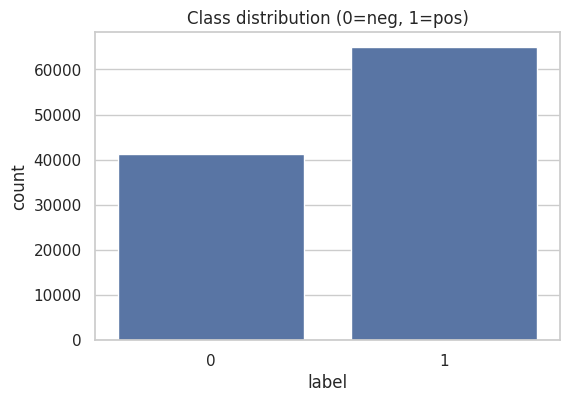

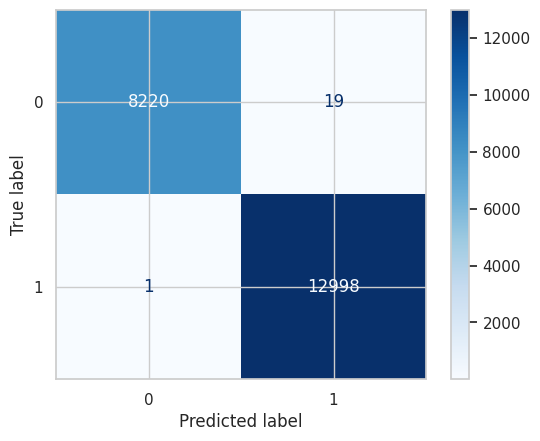

In [16]:
# --------------- 13. Plot class distribution and confusion matrix ---------------
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x=df["label"])
plt.title("Class distribution (0=neg, 1=pos)")
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap="Blues")
plt.show()

## Perform DISTILBERT-BASE-CASE

In [19]:
# Step 0 — Disable W&B to avoid API prompt
import os
os.environ["WANDB_DISABLED"] = "true"

# Prepare HF dataset
train_ds = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_ds  = Dataset.from_dict({"text": X_test.tolist(),  "label": y_test.tolist()})
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch): return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)
train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)
train_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
test_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
args = TrainingArguments(
    output_dir="./transformer_finetune",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_steps=1000,
    disable_tqdm=False,
    seed=42
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds
    )
trainer.train()

eval_result = trainer.evaluate()


Map:   0%|          | 0/84950 [00:00<?, ? examples/s]

Map:   0%|          | 0/21238 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
1000,0.224500
2000,0.071500
3000,0.033500
4000,0.032500
5000,0.018900
6000,0.024200
7000,0.021800
8000,0.016500
9000,0.018700
10000,0.002700


## Model Evaluation

In [20]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Use DataLoader for batching
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

all_preds = []
all_labels = []

for batch in test_loader:
    # Move inputs and labels to GPU
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    # Move predictions and labels back to CPU for storing
    all_preds.extend(preds.cpu().tolist())
    all_labels.extend(labels.cpu().tolist())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("Confusion Matrix:\n", cm)

# Optional: Save predictions
eval_df = pd.DataFrame({"true": all_labels, "pred": all_preds})
eval_df.to_csv("transformer_test_predictions.csv", index=False)
print("Saved predictions to transformer_test_predictions.csv")


Accuracy : 0.9990582917412185
Precision: 0.9985403702850119
Recall   : 0.999923071005462
F1-score : 0.9992312423124231
Confusion Matrix:
 [[ 8220    19]
 [    1 12998]]
Saved predictions to transformer_test_predictions.csv
